In [1]:
import pandas as pd
import spacy
import numpy as np
from spacy import attrs
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import sklearn.cluster
import distance

In [2]:
# Pra não truncar as strings
pd.set_option('display.max_colwidth', -1)

In [3]:
ufpe = pd.read_csv('ufpe.csv')
carnegie = pd.read_csv('carnegie.csv')

In [4]:
# A gente só quer os trabalhos que tenham os abstracts
ufpe = ufpe[ufpe['abstract'] != "Not found"]
ufpe = ufpe.reset_index(drop=True)

In [5]:
ufpe.head()

,year,degree,abstract,university,title
0,2004,Computer Science,"This work aims the study of a dynamically reconfigurable architecture for digital systems fast prototipation, based on Leon CPU. Thus, from a previously established platform, an architecture will be studied that considers dynamic reconfiguration of instructions of a Leon system, in a Virtex-II platform. In this proposal, a Virtex-II component will house the Leon CPU core and all its structure of integration in a fixed area of the FPGA, while part of its instruction structure can be dynamically modified, without be necessary to stop the processor (on-the-fly reconfiguration).",UFPE,ARCHITECTURE FOR STATIC AND DYNAMIC RECONFIGURATION OF INSTRUCTIONS IN THE LEON PROCESSOR
1,2004,Computer Science,"UML is a widespread language in industry and academia. However its se- mantics is still informal and has ambiguities. On the other hand, OhCircus is a formal specification language which unifies Z, CSP, the refinement cal- culus and object-oriented theories. In this work, we are concerned with their integration, translating UML class diagrams into OhCircus specifications. In particular, our approach uses, beyond the syntactic mapping, the concept of class model to capture, naturally, associations and global constraints. Finally, we use our own work to prove the refinement of associations as attributes, a much desired result linking analysis to design and implementation.",UFPE,INTEGRATING UML AND FORMAL METHODS
2,2005,Computer Science,"The Television ́s future is digital and full of interactivity. The televiewer will receive a tv signal with high quality video and audio. Besides, the natural evolution ́s greater contribution, will be the interactivity, that will promote the utopia of social inclusion. This process will provide computing capability to a TV set, allowing people who have never accessed internet and e-mail to do it. In this vanguard scenario, a deep analysis about what interactive services are needed, considering the current communication technology. What are they? How to conceive them? How to design and develop them? This is the main subject of this work. It will also be shown an introduction to the interactive digital television ́s middleware, presenting supporting services and applications, as well as an Application Manager proposal.",UFPE,A Service Development Specification for Interactive Digital Television
3,2005,Computer Science,"The teaching of cardiology starts with the patient ́s physical examination and has, as its most important aspect, the auscultation of the cardiac sounds. The training of a medical student in the auscultation of different cardiac sounds is, therefore, one of the key steps towards the establishment of a clinical diagnosis. In this monography, an infrastructure was built in a hospital, with the support of a personal computer, to allow for the recording of cardiac sounds in children, from the neonatal period to for that purpose, a device was designed and developed for the heart sounds ́ capture as well as software for the recording and reproduction of these sounds. As results of this monograph, a digital heart sounds recording system (hardware and software) was built. This system allows for their reproduction and amplification of the sounds that can be heard through loudspeakers and for their transmission throught e-mail.",UFPE,Electronic Tele-Stethoscope A TOOL IN TELEMEDICINE AND CARDIOLOGY EDUCATION
4,2005,Computer Science,"It is known that successful software development companies are based on an efficient project management methodology. This task, however, is not simple. Firstly, many of the available models (like PMBOK) are generic to projects of any nature, not only to software development. At second, these models often do not apply to all companies’ sizes and structure. This paper approaches these aspects and objectives to: A) Identify an enterprise lifecycle model that classifies the companies according to their maturity and 

In [6]:
print("Quantidade de trabalhos da UFPE:",len(ufpe))

Quantidade de trabalhos da UFPE: 151


In [7]:
carnegie_sample = carnegie.sample(151)
carnegie_sample = carnegie_sample.reset_index(drop=True)

In [8]:
print("Quantidade de trabalhos da Carnegie(sample):",len(carnegie_sample))

Quantidade de trabalhos da Carnegie(sample): 151


In [9]:
nlp = spacy.load('en')

In [10]:
def get_lemma(doc):
    tokens = []
    for token in doc:
        if not token.is_punct and (not token.is_digit) and (not token.is_stop):
            if(len(token.lemma_) > 2):
                tokens.append(token.lemma_)
            
    return tokens

In [11]:
import heapq
import operator

def build_tf_idf_extractor(nlp,df):
    data_index = list(range(0,len(df))) 
    print("Number of documents:",len(df))
    
    # CountVectorizer(): Convert a collection of text documents to a matrix of token counts
    cvec = CountVectorizer(stop_words='english', ngram_range=(1,1), lowercase=False,tokenizer=lambda key: get_lemma(nlp(df.iloc[key]['abstract'])))
    
    # fit(raw_documents, y=None): Learn a vocabulary dictionary of all tokens in the raw documents
    cvec.fit(list(range(0,len(df))))
    
    # transform(raw_documents): Transform documents to document-term matrix
    cvec_counts = cvec.transform(list(range(0,len(df))))
    
    # TfidfTransformer(): Transform a count matrix to a normalized tf or tf-idf representation
    transformer = TfidfTransformer()
    
    transformed_weights = transformer.fit_transform(cvec_counts)
    
    output_dictionaries = []
    output = Counter()
    total_words_processed = 0
    for i,row in df.iterrows():
        weights = transformed_weights.toarray()[i]
        index = np.argmax(weights)
        five_keywords = heapq.nlargest(4, enumerate(weights), key=lambda x: x[1])
        keywords_str = []
        for keyword in five_keywords:
            total_words_processed+=1
            output[cvec.get_feature_names()[keyword[0]].lower()] += 1
            keywords_str.append(cvec.get_feature_names()[keyword[0]].lower())
            
        output_dictionaries.append({'abstract':row['abstract'],'title':row['title'],'keywords':keywords_str,'year':row['year'],'university':row['university'],'degree':row['degree']})
    
    print("total keywords processed:", total_words_processed)
    return output,output_dictionaries

## Entender o que está acontecendo

In [12]:
abstract = ufpe.iloc[0]['abstract']

In [13]:
abstract

'This work aims the study of a dynamically reconfigurable architecture for digital systems fast prototipation, based on Leon CPU. Thus, from a previously established platform, an architecture will be studied that considers dynamic reconfiguration of instructions of a Leon system, in a Virtex-II platform. In this proposal, a Virtex-II component will house the Leon CPU core and all its structure of integration in a fixed area of the FPGA, while part of its instruction structure can be dynamically modified, without be necessary to stop the processor (on-the-fly reconfiguration).'

In [14]:
parsed_abstract = nlp(abstract.lower())

In [15]:
print("Number of words:",len(parsed_abstract))

Number of words: 108


In [16]:
lemmas = get_lemma(parsed_abstract)

In [17]:
print(lemmas)

['work', 'aim', 'study', 'dynamically', 'reconfigurable', 'architecture', 'digital', 'system', 'fast', 'prototipation', 'base', 'leon', 'cpu', 'previously', 'establish', 'platform', 'architecture', 'study', 'consider', 'dynamic', 'reconfiguration', 'instruction', 'leon', 'system', 'virtex', 'platform', 'proposal', 'virtex', 'component', 'house', 'leon', 'cpu', 'core', 'structure', 'integration', 'fixed', 'area', 'fpga', 'instruction', 'structure', 'dynamically', 'modify', 'necessary', 'stop', 'processor', 'fly', 'reconfiguration']


In [18]:
print("Number of words:",len(lemmas))

Number of words: 47


In [19]:
ufpe.head(1)

,year,degree,abstract,university,title
0,2004,Computer Science,"This work aims the study of a dynamically reconfigurable architecture for digital systems fast prototipation, based on Leon CPU. Thus, from a previously established platform, an architecture will be studied that considers dynamic reconfiguration of instructions of a Leon system, in a Virtex-II platform. In this proposal, a Virtex-II component will house the Leon CPU core and all its structure of integration in a fixed area of the FPGA, while part of its instruction structure can be dynamically modified, without be necessary to stop the processor (on-the-fly reconfiguration).",UFPE,ARCHITECTURE FOR STATIC AND DYNAMIC RECONFIGURATION OF INSTRUCTIONS IN THE LEON PROCESSOR


In [20]:
# A função build_tf_idf_extractor() retorna um Counter() com as keywords e 
#    um dicionário com os dados do início + nova coluna com as keywords
ufpe_keywords,dict_ufpe = build_tf_idf_extractor(nlp,ufpe.head(1))

Number of documents: 1
total keywords processed: 4


In [21]:
ufpe_keywords

Counter({'architecture': 1, 'cpu': 1, 'dynamically': 1, 'leon': 1})

In [22]:
dict_ufpe

[{'abstract': 'This work aims the study of a dynamically reconfigurable architecture for digital systems fast prototipation, based on Leon CPU. Thus, from a previously established platform, an architecture will be studied that considers dynamic reconfiguration of instructions of a Leon system, in a Virtex-II platform. In this proposal, a Virtex-II component will house the Leon CPU core and all its structure of integration in a fixed area of the FPGA, while part of its instruction structure can be dynamically modified, without be necessary to stop the processor (on-the-fly reconfiguration).',
  'degree': 'Computer Science',
  'keywords': ['leon', 'architecture', 'cpu', 'dynamically'],
  'title': 'ARCHITECTURE FOR STATIC AND DYNAMIC RECONFIGURATION OF INSTRUCTIONS IN THE LEON PROCESSOR',
  'university': 'UFPE',
  'year': 2004}]

# Processar todo o dataset

In [23]:
ufpe_keywords,dataframe_ufpe = build_tf_idf_extractor(nlp,ufpe)

Number of documents: 151
total keywords processed: 604


In [24]:
pd.DataFrame.from_dict(dataframe_ufpe)

,abstract,degree,keywords,title,university,year
0,"This work aims the study of a dynamically reconfigurable architecture for digital systems fast prototipation, based on Leon CPU. Thus, from a previously established platform, an architecture will be studied that considers dynamic reconfiguration of instructions of a Leon system, in a Virtex-II platform. In this proposal, a Virtex-II component will house the Leon CPU core and all its structure of integration in a fixed area of the FPGA, while part of its instruction structure can be dynamically modified, without be necessary to stop the processor (on-the-fly reconfiguration).",Computer Science,"[leon, cpu, dynamically, reconfiguration]",ARCHITECTURE FOR STATIC AND DYNAMIC RECONFIGURATION OF INSTRUCTIONS IN THE LEON PROCESSOR,UFPE,2004
1,"UML is a widespread language in industry and academia. However its se- mantics is still informal and has ambiguities. On the other hand, OhCircus is a formal specification language which unifies Z, CSP, the refinement cal- culus and object-oriented theories. In this work, we are concerned with their integration, translating UML class diagrams into OhCircus specifications. In particular, our approach uses, beyond the syntactic mapping, the concept of class model to capture, naturally, associations and global constraints. Finally, we use our own work to prove the refinement of associations as attributes, a much desired result linking analysis to design and implementation.",Computer Science,"[ohcircus, refinement, uml, association]",INTEGRATING UML AND FORMAL METHODS,UFPE,2004
2,"The Television ́s future is digital and full of interactivity. The televiewer will receive a tv signal with high quality video and audio. Besides, the natural evolution ́s greater contribution, will be the interactivity, that will promote the utopia of social inclusion. This process will provide computing capability to a TV set, allowing people who have never accessed internet and e-mail to do it. In this vanguard scenario, a deep analysis about what interactive services are needed, considering the current communication technology. What are they? How to conceive them? How to design and develop them? This is the main subject of this work. It will also be shown an introduction to the interactive digital television ́s middleware, presenting supporting services and applications, as well as an Application Manager proposal.",Computer Science,"[interactivity, television, interactive, service]",A Service Development Specification for Interactive Digital Television,UFPE,2005
3,"The teaching of cardiology starts with the patient ́s physical examination and has, as its most important aspect, the auscultation of the cardiac sounds. The training of a medical student in the auscultation of different cardiac sounds is, therefore, one of the key steps towards the establishment of a clinical diagnosis. In this monography, an infrastructure was built in a hospital, with the support of a personal computer, to allow for the recording of cardiac sounds in children, from the neonatal period to for that purpose, a device was designed and developed for the heart sounds ́ capture as well as software for the recording and reproduction of these sounds. As results of this monograph, a digital heart sounds recording system (hardware and software) was built. This system allows for their reproduction and amplification of the sounds that can be heard through loudspeakers and for their transmission throught e-mail.",Computer Science,"[sound, cardiac, auscultation, heart]",Electronic Tele-Stethoscope A TOOL IN TELEMEDICINE AND CARDIOLOGY EDUCATION,UFPE,2005
4,"It is known that successful software development companies are based on an efficient project management methodology. This task, however, is not simple. Firstly, many of the available models (like PMBOK) are generic to projects of any nature, not only to software development. At second, these models often do not apply to all companies’ sizes and stru

In [25]:
len(ufpe_keywords)

467

In [26]:
ufpe_keywords.most_common()

[('software', 9),
 ('game', 7),
 ('model', 6),
 ('datum', 6),
 ('project', 5),
 ('language', 5),
 ('information', 4),
 ('proces', 4),
 ('control', 4),
 ('image', 4),
 ('startup', 4),
 ('busines', 4),
 ('behavior', 3),
 ('portfolio', 3),
 ('company', 3),
 ('attack', 3),
 ('environment', 3),
 ('item', 3),
 ('database', 3),
 ('interactive', 3),
 ('recognition', 3),
 ('process', 3),
 ('entity', 3),
 ('learning', 3),
 ('web', 2),
 ('performance', 2),
 ('manager', 2),
 ('method', 2),
 ('interval', 2),
 ('product', 2),
 ('ieee', 2),
 ('motion', 2),
 ('iso/iec', 2),
 ('gamification', 2),
 ('financial', 2),
 ('programming', 2),
 ('people', 2),
 ('ontology', 2),
 ('interactivity', 2),
 ('cmmi', 2),
 ('proof', 2),
 ('consistency', 2),
 ('som', 2),
 ('management', 2),
 ('change', 2),
 ('protocol', 2),
 ('visualization', 2),
 ('orient', 2),
 ('relational', 2),
 ('code', 2),
 ('social', 2),
 ('thread', 2),
 ('program', 2),
 ('page', 2),
 ('site', 2),
 ('estate', 2),
 ('group', 2),
 ('opinion', 2),
 

In [27]:
carnegie_keywords,dataframe_carnegie = build_tf_idf_extractor(nlp,carnegie_sample)

Number of documents: 151
total keywords processed: 604


In [28]:
pd.DataFrame.from_dict(dataframe_carnegie)

,abstract,degree,keywords,title,university,year
0,"Distributed systems are complex to design, build and debug. Components crash due to software bugs such as unchecked array bounds, logic errors, and unchecked return codes. Components hang due to deadlocks and resource leaks. Instead of relying on failure-proofing the services, we focus on detecting and restarting the failed components. With the concepts and benefits of restarting in mind, I will present a ""watchdog"" service for detecting and recovering from failed components in a distributed system. As a case study, I will describe the design and implementation of a watchdog service for a distributed storage system called Ursa Minor. Experiences and novel extensions will be highlighted.",Computer Science,"[component, service, restart, unchecked]",Robust Detection & Recovery from Service Disruptions in Distributed Systems,Carnegie Mellon,2007
1,"Current planetary rovers rely heavily on explicit instructions given by operators on Earth, wasting a great deal of bandwidth. An onboard science autonomy system is necessary to give rovers an understanding of science data, so that they may make informed, autonomous decisions, allocate bandwidth intelligently, and respond to new discoveries. A reliable rock detector is the first step in understanding local geology and creating such a system. The detection of objects in natural scenes is an open problem that has been addressed by many computer vision and machine learning researchers. It involves a difficult combination of image processing, the use of subtle visual cues, and domain knowledge about the world. A three stage hybrid architecture is presented that handles data from multiple sources and combines computer vision and machine learning techniques to achieve segmentation, detection, and classification of rocks. Results using ground-truthed data from the Atacama Desert in Chile suggest a successful system design.",Computer Science,"[rock, rover, bandwidth, science]",Reliable Rock Detection and Classification for Autonomous Science,Carnegie Mellon,2005
2,"Model checking is a method of building a model of a system and then exhaustively and automatically checking whether that model meets a given specification. In particular, the system could require infinitary descriptions (e.g., runs of a reactive system). Elementary cellular automata (ECA) form simple dynamical systems that exhibit a wide array of behaviors, ranging from trivial to computationally complete. I've built the automata-theoretic support structure to perform model checking on first-order logic formulae on one-way infinite cellular automata. Using these formulae, I separate the 256 different ECAs into distinct behavioral classes.",Computer Science,"[automaton, eca, model, check]",Classification and Automaticity of Discrete Dynamical Systems,Carnegie Mellon,2013
3,"Mobile sensor networks have a variety of applications in security and surveillance. One of the most important considerations for such a mobile sensor network is the problem of how to distribute the sensors to maximize coverage of the space to be monitored and detection of targets. Here we compare several strategies for positioning of mobile sensors, including: stationary sensor placement, sensors that rotate in place, mobile sensors moving between predefined waypoints, and an active search. The active search is a strategy where the mobile sensors repeatedly move to the edge of the recently viewed space in order to view areas which have either not yet been observed, or which have not been observed in a certain amount of time. Data from previous target observations is used to learn a model of target motion, which can be used to predict target movements and areas that targets may be likely to appear. Tests are performed in simulation in order to evaluate the effectiveness of the different sensor positioning strategies and sensor models.",Computer Science,"[sensor, target, mobile, strategy]",Analyzing Mobile Sensor P

In [29]:
len(carnegie_keywords)

472

In [30]:
carnegie_keywords.most_common()

[('object', 7),
 ('robot', 7),
 ('user', 5),
 ('language', 5),
 ('algorithm', 5),
 ('student', 5),
 ('mobile', 4),
 ('game', 4),
 ('recognition', 4),
 ('science', 4),
 ('proof', 4),
 ('learning', 4),
 ('music', 3),
 ('feature', 3),
 ('behavior', 3),
 ('logic', 3),
 ('model', 3),
 ('vehicle', 3),
 ('file', 3),
 ('environment', 3),
 ('state', 3),
 ('network', 3),
 ('service', 3),
 ('dynamic', 3),
 ('online', 3),
 ('domain', 3),
 ('graph', 3),
 ('representation', 3),
 ('activity', 3),
 ('agent', 3),
 ('fmri', 2),
 ('patient', 2),
 ('word', 2),
 ('transducer', 2),
 ('wireless', 2),
 ('motion', 2),
 ('property', 2),
 ('rover', 2),
 ('automaton', 2),
 ('high', 2),
 ('learn', 2),
 ('machine', 2),
 ('evaluation', 2),
 ('formal', 2),
 ('computer', 2),
 ('device', 2),
 ('verify', 2),
 ('problem', 2),
 ('social', 2),
 ('noun', 2),
 ('program', 2),
 ('computation', 2),
 ('architecture', 2),
 ('document', 2),
 ('strategy', 2),
 ('resource', 2),
 ('control', 2),
 ('opponent', 2),
 ('classifier', 2),

# Ver quantos trabalhos 'exclusivos' cada Universidade tem
(trabalhos onde todas as keywords só aparecem uma vez em todo o corpus)

In [31]:
ufpe_keywords.most_common()

[('software', 9),
 ('game', 7),
 ('model', 6),
 ('datum', 6),
 ('project', 5),
 ('language', 5),
 ('information', 4),
 ('proces', 4),
 ('control', 4),
 ('image', 4),
 ('startup', 4),
 ('busines', 4),
 ('behavior', 3),
 ('portfolio', 3),
 ('company', 3),
 ('attack', 3),
 ('environment', 3),
 ('item', 3),
 ('database', 3),
 ('interactive', 3),
 ('recognition', 3),
 ('process', 3),
 ('entity', 3),
 ('learning', 3),
 ('web', 2),
 ('performance', 2),
 ('manager', 2),
 ('method', 2),
 ('interval', 2),
 ('product', 2),
 ('ieee', 2),
 ('motion', 2),
 ('iso/iec', 2),
 ('gamification', 2),
 ('financial', 2),
 ('programming', 2),
 ('people', 2),
 ('ontology', 2),
 ('interactivity', 2),
 ('cmmi', 2),
 ('proof', 2),
 ('consistency', 2),
 ('som', 2),
 ('management', 2),
 ('change', 2),
 ('protocol', 2),
 ('visualization', 2),
 ('orient', 2),
 ('relational', 2),
 ('code', 2),
 ('social', 2),
 ('thread', 2),
 ('program', 2),
 ('page', 2),
 ('site', 2),
 ('estate', 2),
 ('group', 2),
 ('opinion', 2),
 

In [32]:
def get_keywords_with_one_ocurrence(keywords):
    keywords_once_ocurrence = []
    for (word,count) in keywords.most_common():
        if(count == 1):
            keywords_once_ocurrence.append(word)
            
    return keywords_once_ocurrence
    

In [33]:
ufpe_keywords_with_one_ocurrence = get_keywords_with_one_ocurrence(ufpe_keywords)

In [34]:
len(ufpe_keywords_with_one_ocurrence)

380

In [35]:
def get_exclusive_works(dataframe,keywords_one_ocurrence):
    exclusive_tccs = []
    for item in dataframe:
        all_keywords = item['keywords']
        exclusive_keywords_for_tcc = [word for word in all_keywords if word in keywords_one_ocurrence]
        qtd_exclusive_keywords = len(exclusive_keywords_for_tcc)
        if(qtd_exclusive_keywords == 4):
            exclusive_tccs.append(exclusive_keywords_for_tcc)
            
    return exclusive_tccs
        

In [36]:
exclusive_works_ufpe = get_exclusive_works(dataframe_ufpe, ufpe_keywords_with_one_ocurrence)

In [37]:
print("Total de trabalhos da UFPE com keywords exclusivas:",len(exclusive_works_ufpe))

Total de trabalhos da UFPE com keywords exclusivas: 27


In [38]:
exclusive_works_ufpe

[['leon', 'cpu', 'dynamically', 'reconfiguration'],
 ['ohcircus', 'refinement', 'uml', 'association'],
 ['sound', 'cardiac', 'auscultation', 'heart'],
 ['lve', 'module', 'input', 'apprentice'],
 ['function', 'geographic', 'integration', 'analytical'],
 ['signature', 'dpi', 'traffic', 'generator'],
 ['mst', 'tree', 'approximation', 'connect'],
 ['topology', 'search', 'local', 'global'],
 ['timetable', 'schedule', 'make', 'maker'],
 ['checker', 'istartool', 'end', 'improvement'],
 ['vire', 'lo-', 'propagation', 'rfid'],
 ['university', 'society', 'life', 'knowledge'],
 ['bitcoin', 'criptocurrency', 'hash', 'monetary'],
 ['talent', 'player', 'layer', 'gather'],
 ['aids', 'applicability', 'bioinformatic', 'cancer'],
 ['music', 'read', 'rhythm', 'solfege'],
 ['java', 'exception', 'flow', 'epic'],
 ['domestic', 'robot', 'map', 'perform'],
 ['e.g.', 'sharing', 'bicycle', 'boosting'],
 ['fee', 'block', 'transaction', 'reward'],
 ['broadcast', 'match', 'interface', 'esport'],
 ['printing', 'bro

In [39]:
carnegie_keywords_with_one_ocurrence = get_keywords_with_one_ocurrence(carnegie_keywords)

In [41]:
len(carnegie_keywords_with_one_ocurrence)

392

In [42]:
exclusive_works_carnegie = get_exclusive_works(dataframe_carnegie, carnegie_keywords_with_one_ocurrence)

In [43]:
print("Total de trabalhos da Carnegie com keywords exclusivas:",len(exclusive_works_carnegie))

Total de trabalhos da Carnegie com keywords exclusivas: 25


In [44]:
exclusive_works_carnegie

[['sort', 'auto', 'tuning', 'performance'],
 ['pcc', 'tal', 'safe', 'binary'],
 ['string', 'semantic', 'improvement', 'gauge'],
 ['brand', 'tweet', 'centre', 'come'],
 ['thesi', 'cover', 'resynchronization', 'design'],
 ['interruption', 'self', 'effect', 'cause'],
 ['pattern', 'entry', 'excel', 'numerical'],
 ['neumann', 'von', 'viru', 'false'],
 ['exploit', 'heap', 'aeg', 'generation'],
 ['roboceptionist', 'greet', 'people', 'interested'],
 ['spliddit', 'fair', 'division', 'website'],
 ['centric', 'centrality', 'closenes', 'hashtag'],
 ['cloth', 'simulation', 'mesh', 'realistic'],
 ['antidifference', 'karr', 'schneider', 'solve'],
 ['beacon', 'round', 'period', '100ms'],
 ['group', 'transduction', 'question', 'automorphism'],
 ['rate', 'command', 'intel', 'i/o'],
 ['box', 'black', 'white', 'hadoop'],
 ['debugging', 'framework', 'meaningful', 'partition'],
 ['family', 'reminder', 'event', 'parent'],
 ['appearance', 'space', 'deformation', 'pre'],
 ['bayes', 'net', 'inference', 'hierarc

# WordCloud

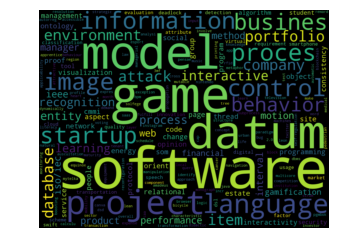

In [45]:
wordcloud = WordCloud(width=1600,height=1200).generate_from_frequencies(ufpe_keywords)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

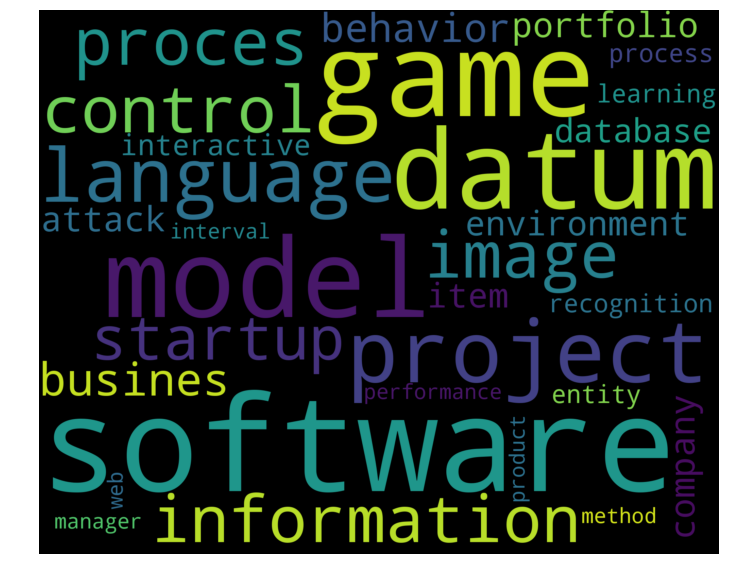

In [46]:
wordcloud = WordCloud(width=2000,height=1600,max_words=30).generate_from_frequencies(ufpe_keywords)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Carnegie

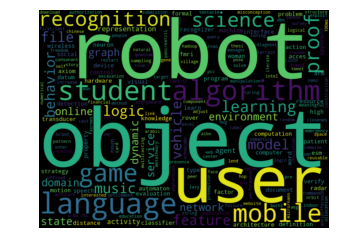

In [47]:
wordcloud = WordCloud(width=1600,height=1200).generate_from_frequencies(carnegie_keywords)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

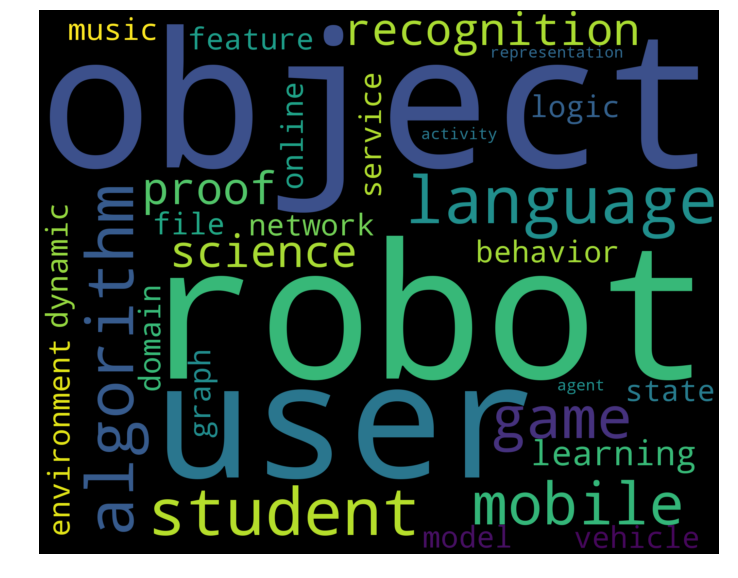

In [48]:
wordcloud = WordCloud(width=2000,height=1600,max_words=30).generate_from_frequencies(carnegie_keywords)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()